In [ ]:
# python collect_jobs_and_clean.py -d /home1/smaruj/akitaV2-analyses/experiments/TAD_boundaries_analysis/boundaries_disruption.tsv 
# -v -l /scratch1/smaruj/tad_disruption/model0_m0/

# python collect_jobs_and_clean.py -d /home1/smaruj/akitaV2-analyses/experiments/TAD_boundaries_analysis/boundaries_disruption_2.tsv 
# -v -l /scratch1/smaruj/tad_disruption/model0_2_m0/

In [1]:
import numpy as np
import pandas as pd
from akita_utils.format_io import h5_to_df

In [2]:
df_1 = h5_to_df("/scratch1/smaruj/tad_disruption/model0_m0/STATS_OUT.h5", average=False)
df_2 = h5_to_df("/scratch1/smaruj/tad_disruption/model0_2_m0/STATS_OUT.h5", average=False)

In [ ]:
# target 1 is Bonev ES Cells, which HiC TAD boundaries have called on

In [5]:
df = pd.concat([df_1, df_2], axis=0, ignore_index=True)

In [3]:
new_type = ["down_5" for i in range(4185)] + ["down_4" for i in range(4185)] + ["down_3" for i in range(4185)] + ["up_3" for i in range(4185)] + ["up_4" for i in range(4185)] + ["up_5" for i in range(4185)]

In [4]:
df_2["type"] = new_type

In [6]:
df

,SCD_h1_m0_t0,SCD_h1_m0_t1,SCD_h1_m0_t2,SCD_h1_m0_t3,SCD_h1_m0_t4,SCD_h1_m0_t5,chrom,end,rel_disruption_end,rel_disruption_start,start,type,window_end,window_start
0,1.271484,1.322266,1.480469,1.338867,1.297852,1.051758,chr1,4410000,647168,645120,4400000,down2,5061504,3750784
1,1.850586,1.778320,1.801758,1.533203,1.512695,1.265625,chr1,5160000,647168,645120,5150000,down2,5811504,4500784
2,1.944336,2.076172,1.750000,1.711914,1.771484,1.463867,chr1,6200000,647168,645120,6190000,down2,6851504,5540784
3,0.854980,0.853027,0.794922,0.838867,0.659668,0.598145,chr1,6440000,647168,645120,6430000,down2,7091504,5780784
4,0.452637,0.517578,0.611328,0.597168,0.531250,0.467773,chr1,6990000,647168,645120,6980000,down2,7641504,6330784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62770,0.684570,0.612305,0.775879,0.733398,0.662598,0.585938,chr19,57370000,669696,667648,57360000,up_5,58021504,56710784
62771,0.771484,0.740723,0.741699,0.741699,0.680176,0.613770,chr19,57670000,669696,667648,57660000,up_5,58321504,57010784
62772,0.634277,0.708496,0.738770,0.750977,0.692383,0.609375,chr19,58680000,669696,667648,58670000,up_5,59331504,58020784
62773,1.318359,1.354492,2.041016,2.154297,1.627930,1.445312,chr19,59390000,669696,667648,59380000,up_5,60041504,58730784


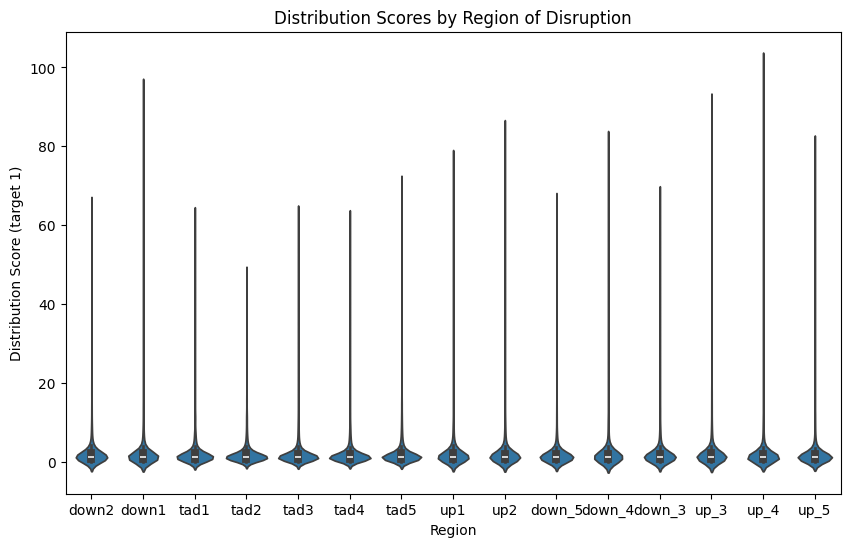

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the figure
plt.figure(figsize=(10, 6))

# Create the violin plot
sns.violinplot(data=df, x='type', y='SCD_h1_m0_t1', inner='box')

# Add labels and title
plt.xlabel('Region')
plt.ylabel('Distribution Score (target 1)')
plt.title('Distribution Scores by Region of Disruption')

# Show the plot
plt.show()

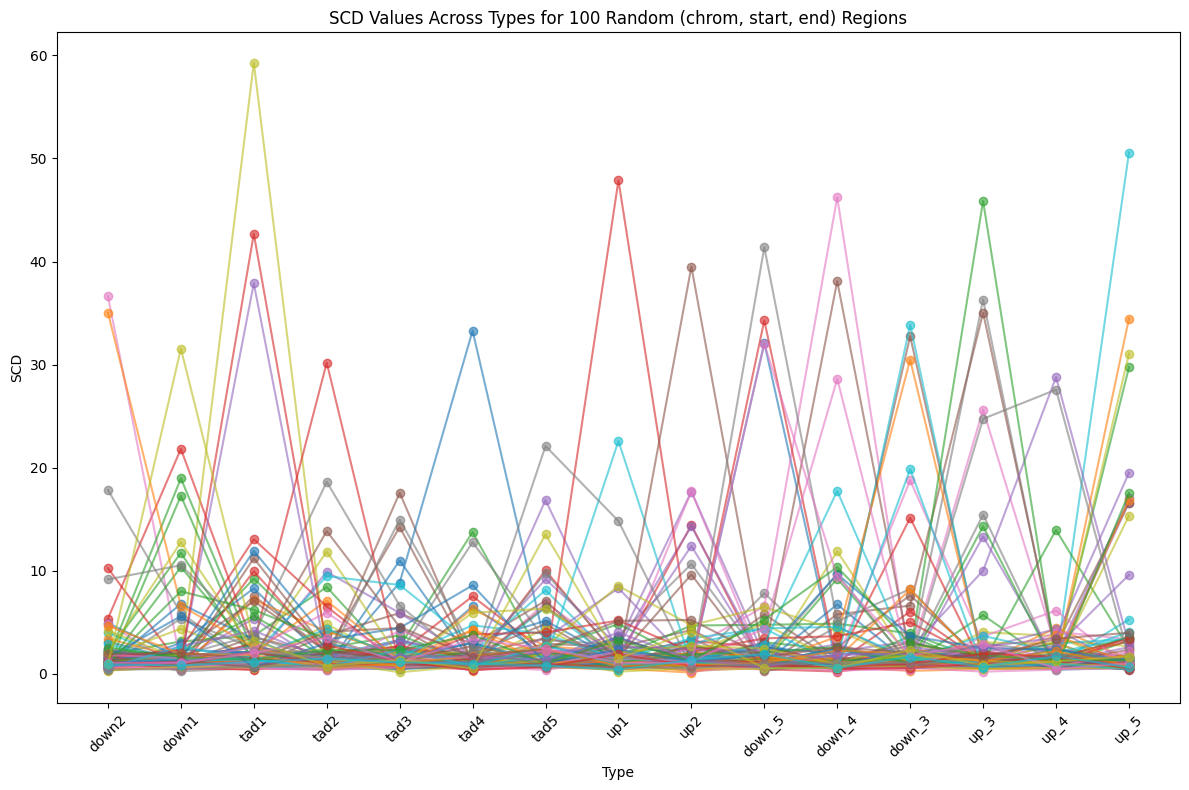

In [9]:
# Randomly sample 100 unique (chrom, start, end) regions
sampled_df = df.drop_duplicates(subset=['chrom', 'start', 'end']).sample(n=100)

# Filter the original dataframe to include only the sampled regions
filtered_df = df[df[['chrom', 'start', 'end']].apply(tuple, axis=1).isin(sampled_df[['chrom', 'start', 'end']].apply(tuple, axis=1))]

# Set up the figure
plt.figure(figsize=(12, 8))

# Get the unique types for ordering on x-axis
unique_types = filtered_df['type'].unique()

# For each sampled region, plot the line connecting SCD values for each type
for (chrom, start, end), group in filtered_df.groupby(['chrom', 'start', 'end']):
    plt.plot(group['type'], group['SCD_h1_m0_t1'], marker='o', label=f"{chrom}:{start}-{end}", alpha=0.6)

# Add labels and title
plt.xlabel('Type')
plt.ylabel('SCD')
plt.title('SCD Values Across Types for 100 Random (chrom, start, end) Regions')

# Optional: Add legend (can be overwhelming with 100 lines)
# plt.legend(loc='best')

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show the plot
plt.show()


In [10]:
# Filter the dataframe for rows where SCD > 15
filtered_df = df[df['SCD_h1_m0_t1'] > 10]

# Count unique (chrom, start, end) combinations
unique_regions_count = filtered_df[['chrom', 'start', 'end']].drop_duplicates().shape[0]

# Output the result
print(f"Number of unique (chrom, start, end) regions with SCD > 10 for at least one type: {unique_regions_count}")


Number of unique (chrom, start, end) regions with SCD > 10 for at least one type: 2371


In [1]:
len(unique_regions_count)

NameError: name 'unique_regions_count' is not defined

In [ ]:
scores_df = pd.read_csv("./boundaries_no_strong_site.tsv", sep="\t")

In [ ]:
import bioframe as bf

In [ ]:
overlapped_df = bf.overlap(df, scores_df, suffixes=("", "_2"), return_index=False, how="left")

In [ ]:
max_scd_df = overlapped_df.groupby(by=["chrom", "start", "end"])["SCD"].max().reset_index()

In [ ]:
mean_ins = overlapped_df.groupby(by=["chrom", "start", "end"])[["log2_insulation_score_200000_2", "n_valid_pixels_200000_2", "boundary_strength_200000_2"]].mean().reset_index()

In [ ]:
# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(max_scd_df["SCD"], mean_ins["log2_insulation_score_200000_2"], alpha=0.7)

# Add labels and title
plt.xlabel('SCD (Max)')
plt.ylabel('Log2 Insulation Score (Mean)')
plt.title('Scatter Plot of SCD vs Log2 Insulation Score')

# Show the plot
plt.show()

In [ ]:
# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(max_scd_df["SCD"], mean_ins["n_valid_pixels_200000_2"], alpha=0.7)

# Add labels and title
plt.xlabel('SCD (Max)')
plt.ylabel('N Valid Pixels')
plt.title('Scatter Plot of SCD vs Log2 Insulation Score')

# Show the plot
plt.show()

In [ ]:
# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(max_scd_df["SCD"], mean_ins["boundary_strength_200000_2"], alpha=0.7)

# Add labels and title
plt.xlabel('SCD (Max)')
plt.ylabel('Boundary Strength')
plt.title('Scatter Plot of SCD vs Log2 Insulation Score')

# Show the plot
plt.show()